# Time series analysis of particle motion

By Michael Hallam.



# Introduction

We use the simulator [TorusParticles](https://github.com/michaelhallam123/TorusParticles), written by the author of this notebook, to simulate particles moving freely on a two-dimensional torus, and study the motion of a large particle moving in a fluid of smaller particles.
<div style="text-align: center;">
   <img src="images/image1.png" alt="Experiment" width="300" class="center"/>
</div>

The particles move without the influence of external forces, and rebound elastically upon collision. Topologically, the world space is a two-dimensional torus: when particles exit the screen on one side, they re-enter from the opposite side.

Over a long period of time the particle's trajectory is unpredictable. However, over a short period of time there is some scope for predicting the particle's motion. We assess the performance of several models for predicting the particle's trajectory over a small time period, measured by the root mean squared error of the predictions one time step in the future. To reduce the risk of overfitting, we use a simple time split validation on a train set, and assess each model's performance on a validation set. After selecting our final model, we assess its performance on a test set.

The models considered are:
- Two-dimensional Brownian motion;
- The Langevin equation;
- General ARIMA(p,d,q) models.

We find that the baseline model of Brownian motion can be significantly improved upon by accounting for the autocorrelation bewteen velocities. Modelling the motion by the Langevin equation, which we view as an ARIMA(1,1,0) model, roughly halves the root mean squared error of predictions. Introducing a moving average term via an ARIMA(1,1,1) model further improves predictions, but only slightly. ARIMA models with other hyperparameters give similar predictions, and we select the ARIMA(1,1,1) as the best performing model using the fewest parameters, again to reduce the risk of overfitting.

## Simulation information

### Parameters and output

The system consists of:
- A $2\,\text{m}\times2\,\text{m}$ world space, topologically wrapped into a torus;
- One particle $P_1$ of mass $6.4\,\text{kg}$, radius $0.15\,\text{m}$;
- Five thousand particles $p_1,\ldots,p_{5000}$ of mass $0.1\,\text{kg}$ and radius $0.005\,\text{m}$;
- Total kinetic energy $7.28877\,\text{J}$;
- Total momentum $(0,0)$.

**Remark:** The particle sizes and masses are unrealistic, but the physics describing the interactions is scale invariant, so these fictional choices could equally be replaced by more appropriate units.

For the simulation, we choose a time increment of $0.01$ seconds. We simulate one million time increments, and record the large particle $P_1$'s new position every 10 increments, or every 0.1 seconds of simulation time, producing one hundred thousand observations. 

Rather than recording the path $[0,T]\to\mathbb{T}^2$ that the particle $P_1$ takes, we instead record its unique lift $[0,T]\to \mathbb{R}^2$ to the universal cover $\mathbb{R}^2\to\mathbb{T}^2$ with starting point $(0,0)$. This ensures continuity of the particle's path when represented by coordinates in $\mathbb{R}^2$.

### Reproducing the experiment

The full code used to generate the data is available as a [branch of TorusParticles](https://github.com/michaelhallam123/TorusParticles/tree/brownian-motion-experiment). Building and running the code produces a csv file `output.csv` in the binary directory, containing the particle position data.

Multithreading is disabled to ensure the experiment is reproducible. To enable multithreading for a faster (but non-deterministic) simulation, alter the value of the class member `NUM_THREADS` in the file `SpatialHashSolver.hpp` to 10.

### Potential limitations

The particle collisions are detected *a posteriori*, meaning the time step is first advanced, and then a search is conducted for collisions. Any intersecting particles then have their positions and velocities adjusted to account for the collision. In particular, this is physically unrealistic. For more accurate results, an *a priori* particle simulation, i.e. one which exactly computes the trajectories of the particles, may be required.

## Candidate models

In this section, we describe the models considered.

### Brownian motion

Recall that two-dimensional [Brownian motion](https://en.wikipedia.org/wiki/Wiener_process) is a stochastic process $\{W_t:t\geq 0\}$ with values in $\mathbb{R}^2$ satisfying the following properties:

1. $W_0 = (0,0)$;
2. $W_t(\omega)$ is continuous in $t$ for all $\omega$ in the sample space;
3. For all $s < t$, $W_t-W_s\sim N((0,0),(t-s)\text{Id}_2)$;
4. For all $t_1 \leq t_2 \leq t_3 \leq t_4$, $W_{t_2}-W_{t_1}$ and $W_{t_4}-W_{t_3}$ are independent.

The prediction produced by Brownian motion is the particle's most recent position: since the distribution of $W_{t+dt}|W_t$ is rotationally symmetric about $W_t$, the best predictor of the particle's position at time $t+dt$ is simply $W_t$.

We will see that Brownian motion is not suitable to describe the motion of the large particle. In particular, on sufficiently small time scales, once the particle has gained inertia it will continue to move in a fixed direction until it is slowed down by the surrounding fluid. This suggests a correlation between increments that is not present in Brownian motion.

### Langevin equation

To account for the inertia accumulated by the large particle during its trajectory on small time scales, a more accurate model than Brownian motion is the [Langevin equation](https://en.wikipedia.org/wiki/Langevin_equation): $$m\,dv_t = -\lambda v_t \,dt + dW_t.$$ Here:

1. $m$ is the mass of the particle;
2. $v_t$ is the velocity of the particle;
3. $\lambda>0$ is the damping coefficient;
4. $W_t$ is Brownian motion.

In particular, the Langevin equation is a stochastic ordinary differential equation; written in integral form it is $$m(v_t-v_0) = -\lambda\int_0^t v_s ds + W_t.$$ Positivity of the damping coefficient $\lambda$ accounts for the surrounding fluid slowing down the large particle. 

Introducing an integrating factor $I(t):= e^{\frac{\lambda}{m}t}$, we may formally solve the Langevin equation to get $$v_t = v_0e^{\frac{-\lambda}{m}t} + \frac{1}{m}\int_0^t e^{-\frac{\lambda}{m}(t-s)}dW_s.$$

We will see that our simulation does not quite follow the Langevin equation, due to the observed noise not being truly Gaussian, but having a distribution with thicker tails. This is perhaps because our simulation is not idealised; we only have 5000 small particles rather than billions of small particles.

Exactly how we train a model based on the Langevin equation is discussed in the following section.

### ARIMA model

The [ARIMA(p,d,q) model](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) is a general model for time series, which stipulates that the d-th order differences of the time series follow an ARMA(p,q) model.

The *first order difference* of a discrete time series $X_t$ with timestep $dt$ is defined by $\Delta X_t := X_t - X_{t-dt}$, and the $d$-th order difference is defined recursively by $\Delta^d X_t := \Delta(\Delta^{d-1}X)_t$. A time series $Y_t$ is said to follow an *ARMA(p,q) model* if it is stationary and there exist constants $\phi_1,\ldots,\phi_p$, $\theta_1,\ldots,\theta_q$, and a white noise random process $\epsilon_t$ such that $$Y_t = \sum_{i=1}^p\phi_i Y_{t-idt} + \sum_{j=1}^q \theta_j\epsilon_{t-jdt} + \epsilon_t.$$

By differencing the time series of the particle's position and using regressive terms, we will be able to account for the particle's inertia, similarly to how the Langevin equation does. In fact, note that if we naively discretise the Langevin equation, we get $$v_{t}=\left(1-\frac{\lambda}{m}dt\right)v_{t-dt}+\epsilon_t,$$ where $\epsilon_t$ is Gaussian noise. In particular, the discretised version of the Langevin equation is an ARMA(1,0) model on the velocity, or equivalently an ARIMA(1,1,0) model on the position.

Thus, we will train an ARIMA(1,1,0) model to model the Langevin equation. We will also adjust the hyperparameters $p,d,q$ to see whether a more general ARIMA model can produce more accurate predictions.

**Remark:** While we do not use this viewpoint, we comment that Brownian motion is also discretely modelled by an ARIMA(1,0,0) model with autoregressive coefficient equal to 1; more general autoregressive coefficients correspond to Brownian motion with drift. Equivalently, Brownian motion is discretely modelled by the unique ARIMA(0,1,0) model.

# Set-up

### Importing the data

In [1]:
# Import required packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
import sklearn
from sklearn.metrics import root_mean_squared_error as rmse
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# Import data from output.csv

# NOTE: output.csv is not included in the GitHub repository for this notebook, but can be generated
# by running the experiment branch of TorusParticles

positions = pd.read_csv("output.csv", dtype=float, index_col=False)

The dataframe `positions` stores the x and y positions of the large particle $P_1$ at each time step:

In [3]:
positions.head()

,x,y
0,0.001295,-0.001068
1,0.003120,-0.001206
2,0.004267,-0.000806
3,0.004944,-0.001369
4,0.004878,-0.002316


We set the simulation time as the index of the dataframe:

In [4]:
# Simulation parameters:
dt = 0.1
numRecords = positions.shape[0]

# Set index to simulation time
positions['t'] = dt * np.arange(0, numRecords, 1)
positions.set_index('t', inplace=True)
positions.head()

,x,y
t,,
0.0,0.001295,-0.001068
0.1,0.003120,-0.001206
0.2,0.004267,-0.000806
0.3,0.004944,-0.001369
0.4,0.004878,-0.002316


### Train-test split

We split the data into a train set `positions_train` containing first 90% of the data, and a test set `positions_test` containing the last 10% of the data, and reserve the test set until our final model has been selected:

In [5]:
numRows = positions.shape[0]

splitIndex = int(0.9 * numRows)

positions_train = positions.iloc[:splitIndex]
positions_test = positions.iloc[splitIndex:]

print("Total records:", numRows)
print("Train size:", positions_train.shape[0])
print("Test size:", positions_test.shape[0])

Total records: 100000
Train size: 90000
Test size: 10000


# Exploratory data analysis

In this section we create plots of the positonal data, as well as first and second order differences of the time series, and look for patterns and autocorrelations in the data to inform model selection.

## Plotting positional data

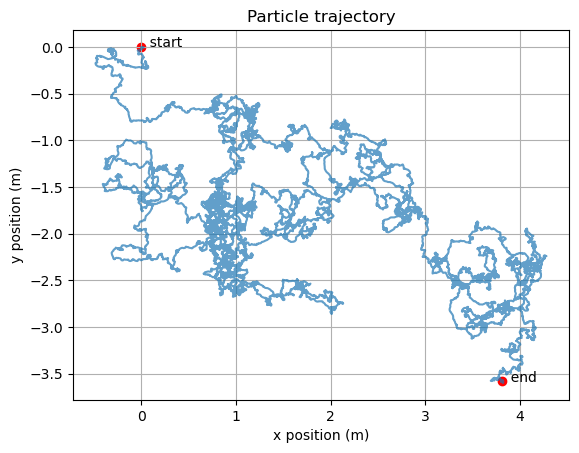

In [7]:
plt.plot(positions_train.x, positions_train.y, alpha=0.7)
plt.grid(True)
plt.title("Particle trajectory")
plt.xlabel("x position (m)")
plt.ylabel("y position (m)")
plt.scatter(0, 0, color='red')
plt.scatter(positions_train.x.iloc[-1], positions_train.y.iloc[-1], color='red')
plt.annotate("  start", (0,0))
plt.annotate("  end", (positions_train.x.iloc[-1], positions_train.y.iloc[-1]))
plt.show()

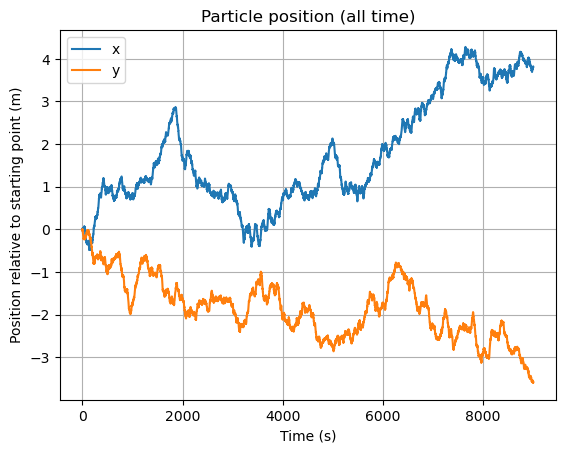

In [26]:
positions_train.plot()
plt.title("Particle position (all time)")
plt.xlabel("Time (s)")
plt.ylabel("Position relative to starting point (m)")
plt.grid(True)
plt.show()

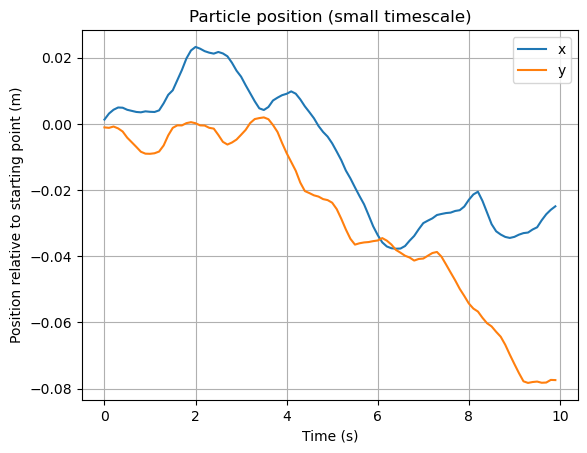

In [27]:
positions_train.iloc[:100].plot()
plt.title("Particle position (small timescale)")
plt.xlabel("Time (s)")
plt.ylabel("Position relative to starting point (m)")
plt.grid(True)
plt.show()

Notice that over a large timescale, the particle's motion appears abrupt and jagged, whereas on a small timescale the motion is relatively smooth. As discussed in the introduction, this indicates that Brownian motion is not the correct model for the particle's motion on small timescales.

## First order differences

In this section we analyse the first order differences $\Delta x_t := x_t - x_{t-dt}$ and $\Delta y_t := y_t - y_{t-dt}$. Rescaling these by $1/dt=1/0.1$ gives the discretised velocity $$v_t := \left(\frac{\Delta x_t}{dt},\frac{\Delta y_t}{dt}\right)$$ at time $t$.

In [28]:
velocities = positions_train.diff().dropna().apply(lambda z : z/dt)

velocities.head()

,x,y
t,,
0.1,0.01825,-0.00138
0.2,0.01147,0.00400
0.3,0.00677,-0.00563
0.4,-0.00066,-0.00947
0.5,-0.00629,-0.01860


### Plotting the velocity

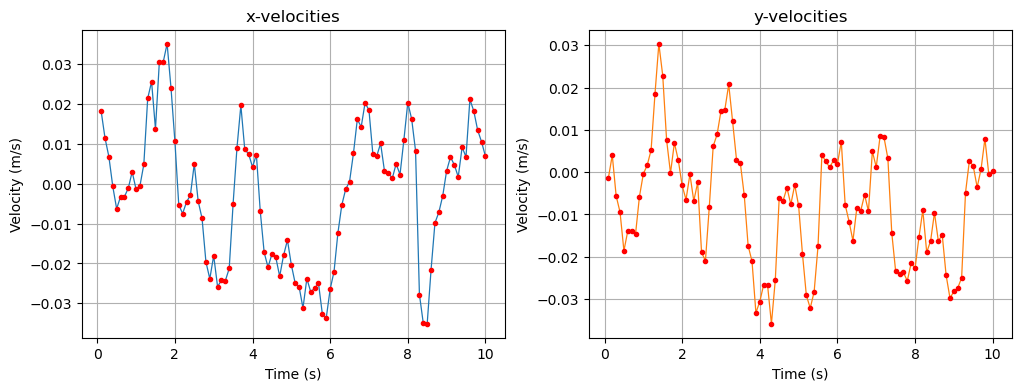

In [29]:
def plotXYData(data, dataName, yLabel, maxInd):
    '''
    Plots the first "maxInd" entries of the dataframe "data" with columns "x" and "y".
    "dataName" is used to generate the plot's title, and "yLabel" corresponds to the y-label of the plot.
    '''
    fig, axes = plt.subplots(1, 2)
    fig.set_figheight(4)
    fig.set_figwidth(12)
    colors = ['#1f77b4', '#ff7f0e']
    for i, col in enumerate(data.columns):
        ax = axes[i]
        color = colors[i]
        ax.plot(data[col].iloc[:maxInd], color, lw=0.9)
        ax.plot(data[col].iloc[:maxInd], 'r.', lw=0.3)
        ax.set_title(col + "-" + dataName)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel(yLabel)
        ax.grid(True)

    plt.show()

plotXYData(velocities, "velocities", "Velocity (m/s)", 100)

From the above plot, we see that $\Delta x_t$ is significantly influenced by $\Delta x_{t-dt}$, and similarly $\Delta y_t$ by $\Delta y_{t-dt}$. We will later quantify the dependence of previous velocities on past velocities using autocorrelation. For Brownian motion the first order differences are white noise, so the graph provides further evidence that the particle does not follow Brownian motion.

### Distribution of velocities

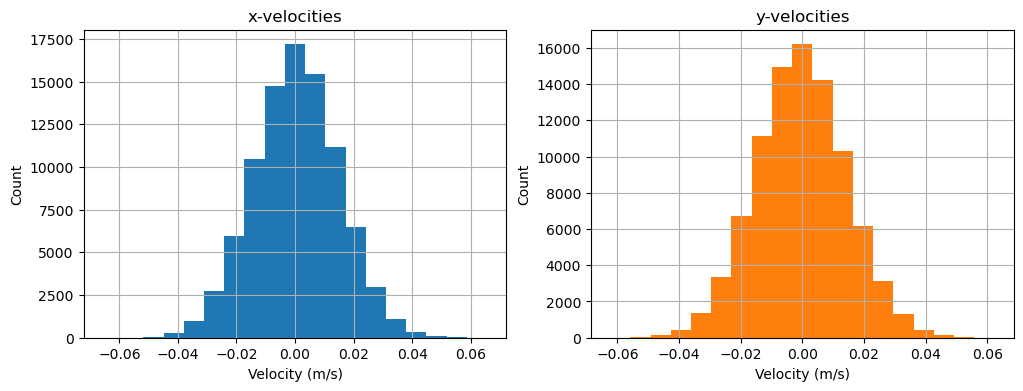

In [30]:
def plotHists(data, dataName, xLabel):
    ''' 
    Plots histograms of the columns "x" and "y" in the dataframe "data".
    "xlabel" specifies the x-label of the plot.
    '''
    fig, axes = plt.subplots(1, 2)
    fig.set_figheight(4)
    fig.set_figwidth(12)
    colors = ['#1f77b4', '#ff7f0e']

    for i, col in enumerate(data.columns):
        ax = axes[i]
        endpoint = max(abs(data[col].min()), abs(data[col].max()))
        ax.hist(data[col], bins = np.linspace(-endpoint, endpoint, 20), color=colors[i])
        ax.set_title(col + "-" + dataName)
        ax.set_ylabel("Count")
        ax.set_xlabel(xLabel)
        ax.grid(True)

    plt.show()

plotHists(velocities, "velocities", "Velocity (m/s)")

The data appear relatively normal, although slightly skewed: x-velocities are slighty positively skewed, and y-velocities are slightly negatively skewed. This is in accordance with the particle's final position:

In [31]:
print("Particle's final position on train set: ({0}, {1})".format(positions_train.iloc[-1].x, positions_train.iloc[-1].y))

Particle's final position on train set: (3.814472, -3.584258)


Integrating the velocities over time gives the particle's final position, hence we know that there must be a greater proportion of positive x-velocities than negative x-velocities, and similarly there must be a greater proportion of negative y-velocities than positive y-velocities.

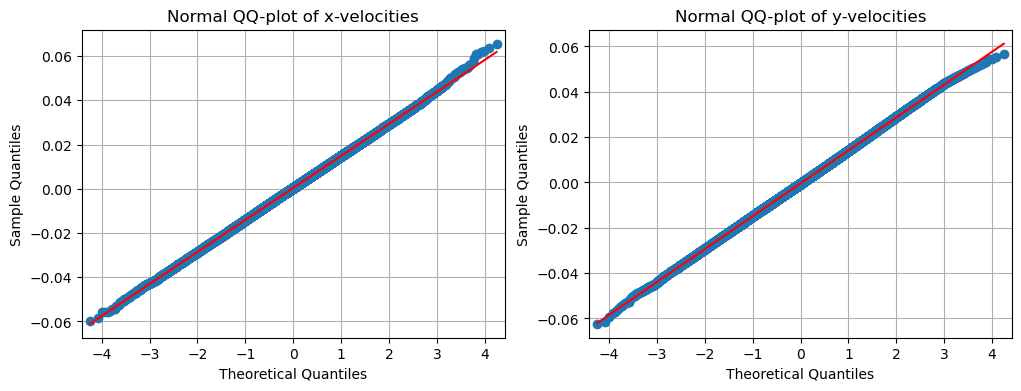

In [32]:
def QQPlot(data, dataName):
    ''' 
    Generate normal QQ-plots of the columns "x" and "y" in the dataframe "data".
    "dataName" is used to generate the title of the plot.
    '''
    fig, axes = plt.subplots(1, 2)
    fig.set_figheight(4)
    fig.set_figwidth(12)

    for i, col in enumerate(data.columns):
        ax = axes[i]
        sm.qqplot(data[col], line='s', ax=ax)
        ax.grid(True)
        ax.set_title("Normal QQ-plot of " + col + "-" + dataName)
    plt.show()

QQPlot(velocities, "velocities")

The above QQ-plots show that the $\Delta x_t$ and $\Delta y_t$ are fairly close to normally distributed, with slightly different behaviour on the tails.

To view the joint distribution of the velocities, we plot a density heatmap.

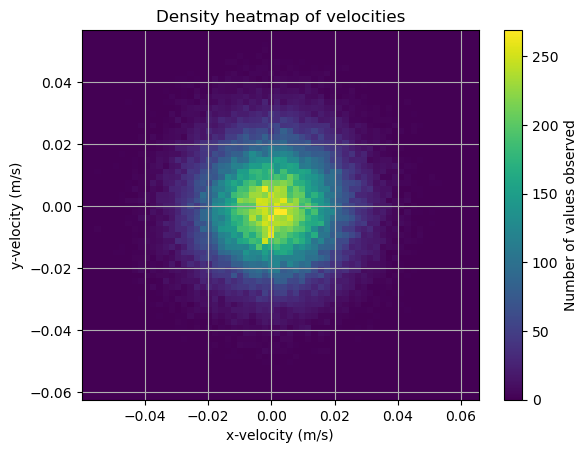

In [33]:
def plotHeatmap(data, dataName, xLabel, yLabel):
    '''
    Plot a 2D heatmap of the columns "x" and "y" in the dataframe "data".
    x- and y-labels are specified with "xLabel" and "yLabel".
    '''
    plt.hist2d(data.x, data.y, bins=64)
    plt.title("Density heatmap of " + dataName)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.grid(True)
    plt.colorbar(label="Number of values observed")
    plt.show()

plotHeatmap(velocities, "velocities", "x-velocity (m/s)", "y-velocity (m/s)")

### Autocorrelation

We now compute the (sample) autocorrelation function (ACF) and partial autocorrelation function (PACF) of the velocity data.

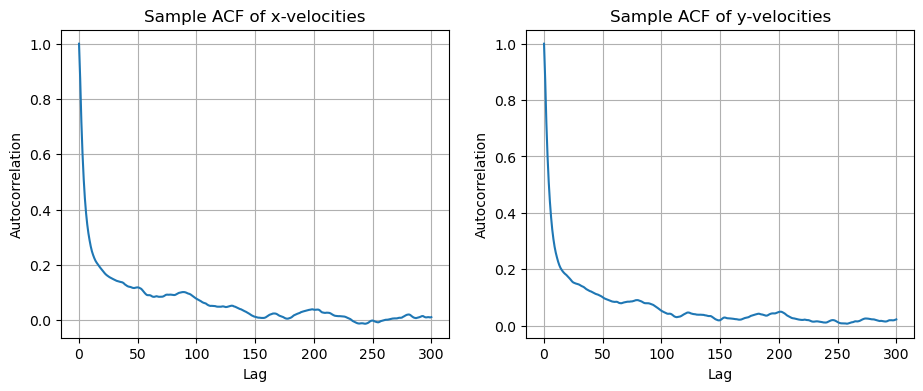

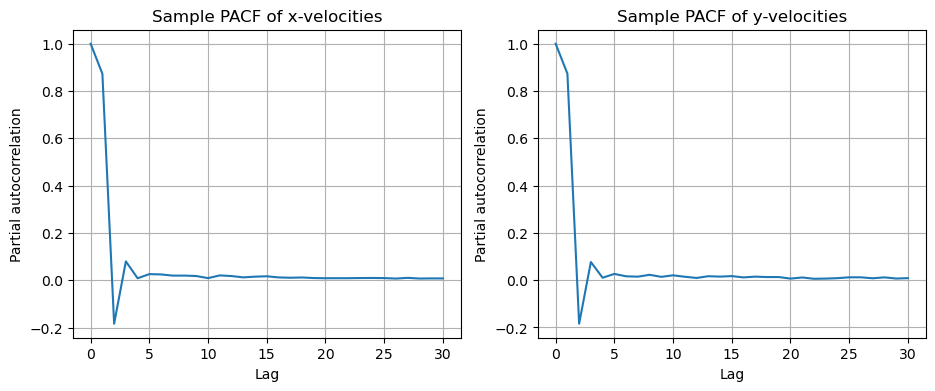

In [34]:
def plotACF(data, dataName, nLags, partial):
    ''' 
    Plots the sample ACF or sample PACF of the columns "x" and "y" in dataframe "data" with max number of lags "nLags".
    For PACF set "partial" to False, for ACF set "partial" to true.
    "dataName" is used to generate the titles.
    '''
    fig, axes = plt.subplots(1, 2)
    fig.set_figheight(4)
    fig.set_figwidth(11)

    for i, col in enumerate(data.columns):
        ax = axes[i]
        if (partial):
            ax.plot(pacf(data[col], nlags=nLags))
            ax.set_title("Sample PACF of " + col + "-" + dataName)
            ax.set_ylabel("Partial autocorrelation")
        else:
            ax.plot(acf(data[col], nlags=nLags))
            ax.set_title("Sample ACF of " + col + "-" + dataName)
            ax.set_ylabel("Autocorrelation")
        ax.grid(True)
        ax.set_xlabel("Lag")

    plt.show()

plotACF(velocities, "velocities", 300, False)
plotACF(velocities, "velocities", 30, True)


From the above, we see there is a strong autocorrelation that decays over time. It takes roughly 150 samples, or 15 seconds simulation time, for the correlation between previous velocities to become negligible. However, accounting for regressive effects using partial autocorrelation, the dependence on previous times decays fairly rapidly.

## Second order differences

Taking the second order differences $\Delta^2 x_t:=\Delta x_t - \Delta x_{t-dt}$ and $\Delta^2 y_t := \Delta y_t - \Delta y_{t-dt}$, we get rescaled discretisations of the acceleration: $$a_t = \left(\frac{\Delta ^2 x_t}{dt^2}, \frac{\Delta^2 y_t}{dt^2}\right).$$

### Plotting the acceleration

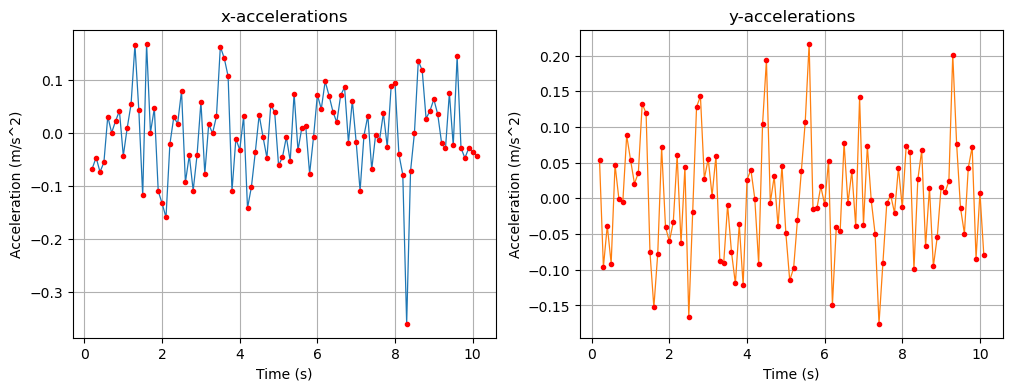

In [35]:
accelerations = velocities.diff().dropna().apply(lambda x : x / dt)

plotXYData(accelerations, "accelerations", "Acceleration (m/s^2)", 100)

At first glance, the second order differences appear to behave much more noisily than the first order differences. We will again make this precise by analysing the autocorrelation function of the acceleration data.

### Distribution of the accelerations

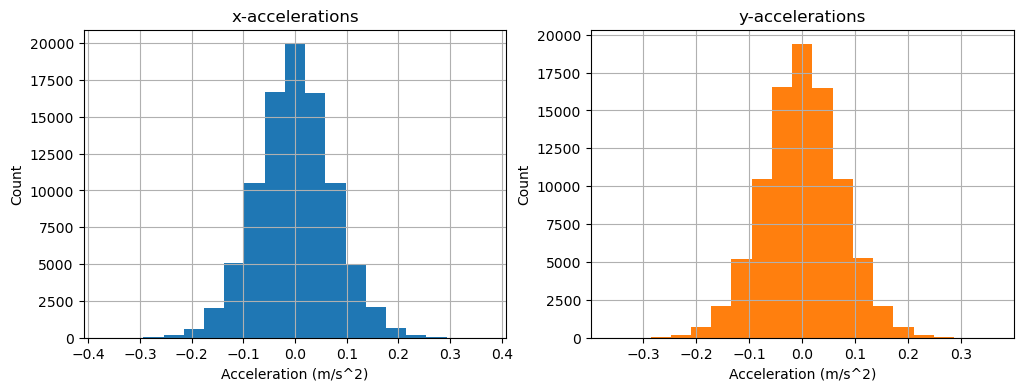

In [36]:
plotHists(accelerations, "accelerations", "Acceleration (m/s^2)")

The slight skew observed in the velocity distributions is no longer present, and the acceleration data appear much more symmetric about the origin.

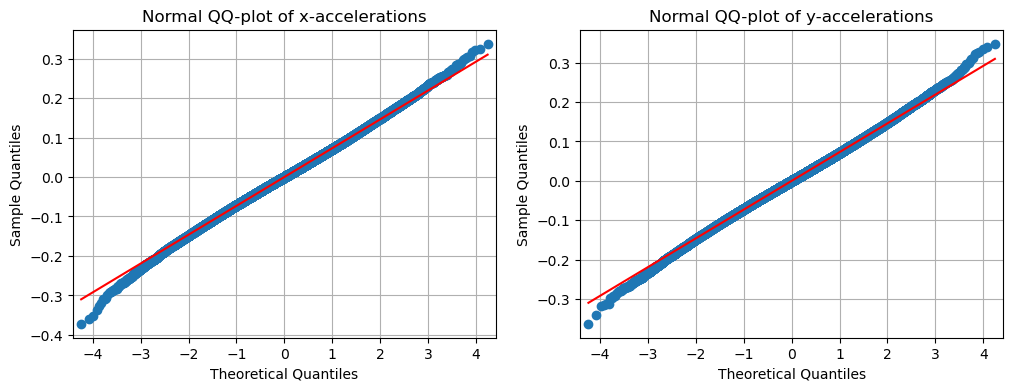

In [37]:
QQPlot(accelerations, "accelerations")

Here we see a more significant departure from the normal distribution; the tails of the distributions of both the x and y components of acceleration are noticably heavier than that of a normal distribution.

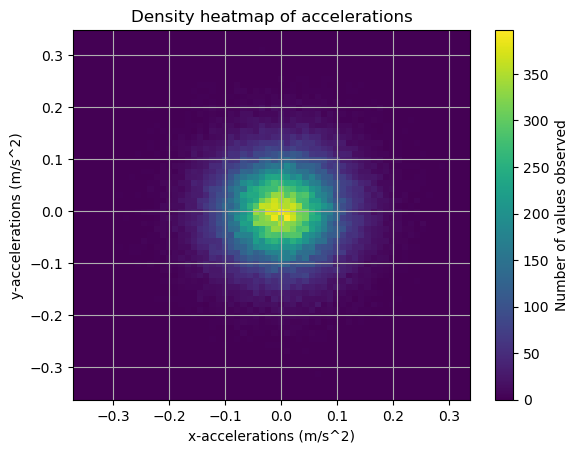

In [38]:
plotHeatmap(accelerations, "accelerations", "x-accelerations (m/s^2)", "y-accelerations (m/s^2)")

Comparing this heatmap to the heatmap of the velocity data, we notice that the central bright region occupies a smaller percentage of the image. This is due to the heavier tails of the acceleration distribution producing more extreme values, which the method `pyplot.hist2d` ensures are in the frame.

### Autocorrelation

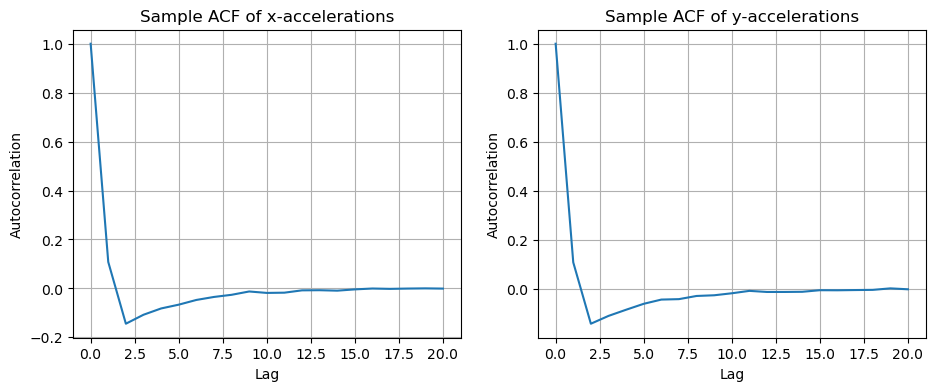

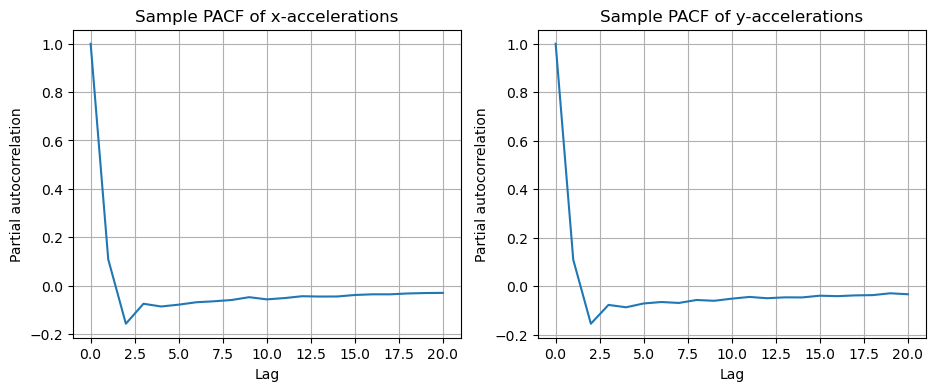

In [39]:
plotACF(accelerations, "accelerations", 20, False)
plotACF(accelerations, "accelerations", 20, True)

Unlike the velocity values, the accelerations exhibit very little dependence on previous values, with the autocorrelation and partial autocorrelation functions decaying much more rapidly.

# Model analysis

## Methodology

In this section, we train several models on the position data and assess their performance using simple time split validation. That is, we split `positions_train` into a smaller train set `train_split`, consisting of the first 90% of entries and a validation set `validation_split` consisting of the final 10% of entries. We withhold data from `positions_test` until the final model is selected.

For certain time series models, it is necessary to retrain the model on new data each time a prediction is made, to ensure the model can adapt to new changes in the underlying system. In this case, the underlying physics of our system remain unchanged over time, so it suffices to train the model once on a sufficiently large data set, and apply it without retraining.

For the error metric, we choose the root mean squared error. The performance of a model is assessed by taking the root mean squared error between the predictions one time step in the future (i.e. given all past data) and the true value of the particle's position one time step in the future. To prevent overfitting, we are seeking the model with the best performance on the validation set `validation_split`.


In order to train ARIMA models using the `statsmodels` package, we will need to convert the indices in the dataframes to datetime objects:

In [40]:
new_train = positions_train.set_index(pd.to_datetime(positions_train.index, unit='s')).asfreq("100ms")
new_test = positions_test.set_index(pd.to_datetime(positions_test.index, unit='s')).asfreq("100ms")

new_train.head()

,x,y
t,,
1970-01-01 00:00:00.000,0.001295,-0.001068
1970-01-01 00:00:00.100,0.003120,-0.001206
1970-01-01 00:00:00.200,0.004267,-0.000806
1970-01-01 00:00:00.300,0.004944,-0.001369
1970-01-01 00:00:00.400,0.004878,-0.002316


In [41]:
numDataPoints = new_train.shape[0]

trainSize = 0.9

separatingIndex = int(trainSize * numDataPoints)

train_split = new_train.iloc[:separatingIndex]
validation_split = new_train.iloc[separatingIndex:]

In [42]:
print(train_split.shape, validation_split.shape)

(81000, 2) (9000, 2)


## Model training

### Brownian motion

For a baseline model, we assume the particle follows Brownian motion. In particular, for our prediction we choose the particle's position at time $t$ as the predictor for its position at time $t+dt$.

There are no parameters to train here, so we may simply proceed straight to the evaluation of the model.

In [44]:
train_truevals = train_split.iloc[1:]
train_predictions_BM = train_split.iloc[:-1]

validation_truevals = validation_split.iloc[1:]
validation_predictions_BM = validation_split.iloc[:-1]

def predictionErrors(train_predictions, validation_predictions, startInd):
    ''' 
    Computes and prints the RMSE between "train_predictions" and train_split, and "validation_predictions" and validation_split.
    The starting index from which the predictions are being made is specified by "startInd".
    Returns a tuple (trainError, validationError), consisting of the RMSE on the train split and the validation split.
    '''
    trainError = rmse(train_truevals[startInd:], train_predictions)
    validationError = rmse(validation_truevals[startInd:], validation_predictions)
    print("Train RMSE:     ", trainError)
    print("Validation RMSE:", validationError)
    return (trainError, validationError)

print("Prediction errors for Brownian motion model:")
trainErrorBM, validationErrorBM = predictionErrors(train_predictions_BM, validation_predictions_BM, 0)

Prediction errors for Brownian motion model:
Train RMSE:      0.0014538735348364838
Validation RMSE: 0.0014258620800762364


### Langevin equation

Recall in the introduction, we remarked that the Langevin equation $$m\, dv_t = -\lambda v_t\, dt + dW_t$$ may be discretised as an ARIMA(1,1,0) model $$v_{t}=\left(1-\frac{\lambda}{m}dt\right)v_{t-dt}+\epsilon_t.$$ Thus, in this section we train an ARIMA(1,1,0) model on `train_split` and assess its performance on both `train_split` and `validation_split`. Checking the parameters of the model, we can estimate the damping coefficient $\lambda$ of the Langevin equation.

In [45]:
# Instantiate models
xLangevinModel = ARIMA(train_split.x, order = (1,1,0))
yLangevinModel = ARIMA(train_split.y, order = (1,1,0))

# Train models
xLangevinModel = xLangevinModel.fit(method_kwargs={"warn_convergence": False})
yLangevinModel = yLangevinModel.fit(method_kwargs={"warn_convergence": False})

In [46]:

# Apply model to new data to make predictions on it using predict()
xLangevinModelVal = xLangevinModel.apply(validation_split.x)
yLangevinModelVal = yLangevinModel.apply(validation_split.y)

# Collect predictions on train and validation splits into dataframes
train_predictions_Langevin = pd.concat([
    xLangevinModel.predict(1), 
    yLangevinModel.predict(1)], 
    axis=1)

validation_predictions_Langevin = pd.concat([
    xLangevinModelVal.predict(1), 
    yLangevinModelVal.predict(1)], 
    axis=1)

train_predictions_Langevin.columns = ["x", "y"]
validation_predictions_Langevin.columns = ["x", "y"]

train_predictions_Langevin.head()

,x,y
t,,
1970-01-01 00:00:00.100,0.001295,-0.001068
1970-01-01 00:00:00.200,0.004714,-0.001327
1970-01-01 00:00:00.300,0.005269,-0.000456
1970-01-01 00:00:00.400,0.005535,-0.001861
1970-01-01 00:00:00.500,0.004820,-0.003144


In [47]:
print("Prediction errors for Langevin model:")
trainErrorLangevin, validationErrorLangevin = predictionErrors(train_predictions_Langevin, validation_predictions_Langevin, 0)

Prediction errors for Langevin model:
Train RMSE:      0.0007065904060782845
Validation RMSE: 0.0007071985019009503


We can see a significant improvement in the root mean squared error: it is roughly halved on both the training set and the validation set.

#### Estimating the damping coefficient

As promised, we can check the parameters of the trained model to get a point estimate $\hat{\lambda}$ for the damping coefficient $\lambda$. We will average the autoregressive coefficients for the x and y data in the ARIMA(1,1,0) model to get a single estimate of the autoregressive coefficient.

In [48]:
print("Parameters for x-values:")
print(xLangevinModel.params)
print()
print("Parameters for y-values:")
print(yLangevinModel.params)

Parameters for x-values:
ar.L1     8.734500e-01
sigma2    4.999513e-07
dtype: float64

Parameters for y-values:
ar.L1     8.744595e-01
sigma2    4.985602e-07
dtype: float64


In [50]:
ARcoef = (xLangevinModel.params["ar.L1"] + yLangevinModel.params["ar.L1"])/2
print("Estimate of autoregressive coefficient:", ARcoef)

Estimate of autoregressive coefficient: 0.8739547287870032


Averaging the parameters for the x and y models, we see that the autoregressive coefficient with lag 1 (`ar.L1`) is approximately 0.87395. We have $$1-\frac{\hat{\lambda}}{m}dt = 0.87395,$$ which we rearrange (recalling $m=6.4\,\text{kg}$) to get $$\hat{\lambda} = \frac{m}{dt}(1-0.87395)=8.0672\,\text{kg/s}.$$

Assuming the Langevin model holds for our system, then the residuals $$ma_t+\hat{\lambda}v_t,$$ should roughly be normally distributed IID random variables.

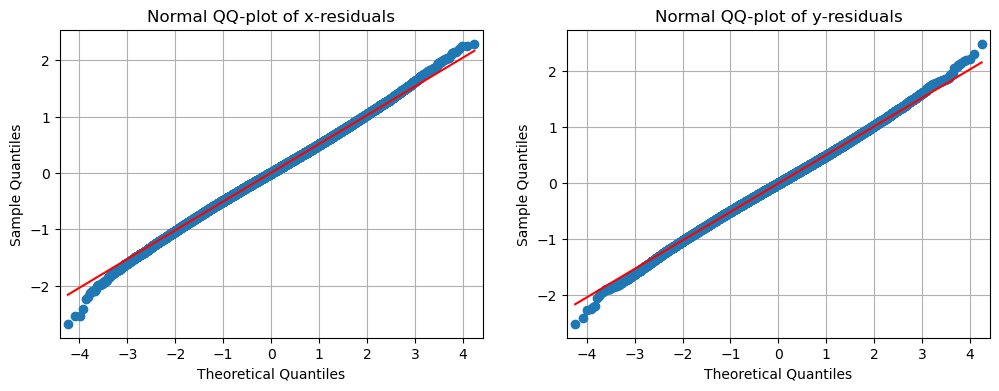

In [51]:
mass = 6.4
lambda_hat = (mass/dt)*(1-ARcoef)

residuals = pd.DataFrame(np.concatenate([
    (mass * accelerations.x.to_numpy() + lambda_hat * velocities.x.iloc[1:].to_numpy()).reshape((-1,1)),
    (mass * accelerations.y.to_numpy() + lambda_hat * velocities.y.iloc[1:].to_numpy()).reshape((-1,1))],
    axis=1))

residuals.columns = ["x", "y"]

QQPlot(residuals, "residuals")

We see the residuals are not quite normal, indicating that the Langevin equation does not hold in the exact sense.

### General ARIMA models

Finally we consider a general ARIMA(p,d,q) model for the particle's motion. We test a range of parameters $(p,d,q)\in [0,2]\times[1,2]\times[0,2]$ and see which gives the best performance on the validation set.

In [52]:
def modelARIMA(p, d, q):
    ''' 
    Train an ARIMA(p,d,q) model on train_split, and print its prediction RMSE on both train_split and validation_split.
    Returns a tuple ((xARIMAModel, yARIMAModel), (trainError, validationError)), where xARIMAModel and yARIMAModel are
    the ARIMA models trained on the x and y data respectively, and trainError and validationError are the RMSEs on the 
    train split and validation split respectively.
    '''
    xARIMAModel = ARIMA(train_split.x, order = (p,d,q))
    yARIMAModel = ARIMA(train_split.y, order = (p,d,q))

    xARIMAModel = xARIMAModel.fit(method_kwargs={"warn_convergence": False})
    yARIMAModel = yARIMAModel.fit(method_kwargs={"warn_convergence": False})
    
    xARIMAModelVal = xARIMAModel.apply(validation_split.x)
    yARIMAModelVal = yARIMAModel.apply(validation_split.y)

    train_predictions_ARIMA = pd.concat([
        xARIMAModel.predict(d), 
        yARIMAModel.predict(d)], 
        axis=1)

    validation_predictions_ARIMA = pd.concat([
        xARIMAModelVal.predict(d), 
        yARIMAModelVal.predict(d)], 
        axis=1)

    train_predictions_ARIMA.columns = ["x", "y"]
    validation_predictions_ARIMA.columns = ["x", "y"]

    print()
    print("Prediction errors for ARIMA model with parameters ({0},{1},{2}):".format(p, d, q))
    return ((xARIMAModel, yARIMAModel),
            predictionErrors(train_predictions_ARIMA, validation_predictions_ARIMA, d-1))

modelErrors = {}

print("-" * 58)
print()
print("d=1 tests:")
# Tests with d=1
for p in range(1, 3):
    for q in range(0, 3):
        modelErrors[(p, 1, q)] = modelARIMA(p, 1, q)

print()
print("-" * 58)
print()
print("d=2 tests:")

# Tests with d=2
for p in range(0, 2):
    for q in range(0, 2):
        modelErrors[(p, 2, q)] = modelARIMA(p, 2, q)

print()
print("-" * 58)

----------------------------------------------------------

d=1 tests:

Prediction errors for ARIMA model with parameters (1,1,0):
Train RMSE:      0.0007065904060782845
Validation RMSE: 0.0007071985019009503

Prediction errors for ARIMA model with parameters (1,1,1):
Train RMSE:      0.0006929980548074169
Validation RMSE: 0.0006930653902734578

Prediction errors for ARIMA model with parameters (1,1,2):
Train RMSE:      0.0006927297264610621
Validation RMSE: 0.0006928636942732152

Prediction errors for ARIMA model with parameters (2,1,0):
Train RMSE:      0.0006946283178745397
Validation RMSE: 0.0006946285816592185

Prediction errors for ARIMA model with parameters (2,1,1):
Train RMSE:      0.000692976048647125
Validation RMSE: 0.00069307500150206

Prediction errors for ARIMA model with parameters (2,1,2):
Train RMSE:      0.0006917961049009143
Validation RMSE: 0.0006922742811027239

----------------------------------------------------------

d=2 tests:

Prediction errors for ARIMA mod

From the results, we see that the ARIMA models with d=1 all have fairly similar performance. We can squeeze out slightly better performance than the ARIMA(1,1,0) model by incorporating extra moving average or autoregressive terms into the model. The best performance on the validation set was given by the ARIMA(2,1,2) model, however the difference between the performance of this model and the ARIMA models with parameters (1,1,1), (2,1,1), and (1,1,2), is close to negligible, and potentially due to randomness. Thus, amongst these models we prefer the one with the least parameters, namely ARIMA(1,1,1), to reduce the risk of overfitting.

While still significantly better than the Brownian motion model, the ARIMA models with d=2 are outperformed by the ARIMA models with d=1.

## Validation on test set

Having selected our preferred model, the ARIMA(1,1,1) model, we evaluate its performance on the test set.

In [53]:
xFinalModel, yFinalModel = modelErrors[(1,1,1)][0]

xFinalModel = xFinalModel.apply(new_test.x)
yFinalModel = yFinalModel.apply(new_test.y)

test_predictions_final = pd.concat([
    xFinalModel.predict(1), 
    yFinalModel.predict(1)], 
    axis=1)

test_predictions_final.columns = ["x", "y"]

testError = rmse(new_test[1:], test_predictions_final)

print("RMSE of ARIMA(1,1,1) model on test set:", testError)

RMSE of ARIMA(1,1,1) model on test set: 0.0006971669437471624


# Conclusion

The Brownian motion model gave a baseline RMSE of 0.0014258 on the validation set. As anticipated, by using more complex models accounting for autocorrelation of velocities, we were able to significantly improve upon this baseline performance.

The Langevin equation, modelled by an ARIMA(1,1,0) process, gave very close to the best predictions on the validation set, with a RMSE of 0.0007072. By inspecting the ARIMA model's parameters we were able to estimate the damping coefficient $\lambda$ of the equation. We observed that the Langevin equation does not truly hold in that the residuals are not normally distributed. Furthermore, the increased performance of ARIMA models with extra autoregressive and moving average terms indicated that the Langevin equation was not capturing all the complexities of this particular system.

We found that an ARIMA(1,1,1) model was the simplest model that gave the best predictions on the validation set, with a root mean squared error of 0.0006931, outperforming both the Brownian motion model with RMSE 0.0014258, and the Langevin model (or ARIMA(1,1,0)) with RMSE 0.0007072. While other ARIMA models with d=1 were able to give slightly better predictions on the validation set, the performance increases were negligible to the extent that they did not warrant the introduction of extra parameters to the model. While still significantly better than the Brownian motion model, ARIMA models with d=2 performed worse than those with d=1 across the board.

The final prediction error of the ARIMA(1,1,1) model on the test set was 0.0006972.